# WEEK 4:

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import requests
import geocoder # import geocoder
from geopy.geocoders import Nominatim 
import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CLIENT_ID = 'NNO2TDZ2XO2YHCMISLHPTUFBAK0YDZBX3RTF04YY4Q5FVR1W' # your Foursquare ID
CLIENT_SECRET = 'UTNENPNX0IFTQP1VPKXI035AFXQEC5XJCN0XJ5YRMYB05HAH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500, LIMIT=20000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
def clusterCorrelations(corr_matrix, cluster_number, sortby_corr_strength=False):
    kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(corr_matrix)
    corr_matrix['cluster_labels']=kmeans.labels_
        
    cluster_labels_df=corr_matrix['cluster_labels'].value_counts().to_frame()
    cluster_labels_df=cluster_labels_df.rename(columns={'cluster_labels': 'cluster_size'})
    
    for i in range(0, cluster_number):
        cluster_types=corr_matrix[corr_matrix.cluster_labels==i].index.values.tolist()
        cluster_labels_df.loc[i, 'corr_strength']= np.abs(corr_matrix.loc[cluster_types, cluster_types].mean().mean())
        
    cluster_labels_df['new label']=1
    if sortby_corr_strength:
        cluster_labels_df['new label']=cluster_labels_df.sort_values('corr_strength', ascending=False)['new label'].cumsum()
        cluster_size_list=cluster_labels_df.sort_values('corr_strength', ascending=False).cluster_size.values.tolist()
        display(cluster_labels_df[['new label', 'corr_strength', 'cluster_size']].sort_values('corr_strength', ascending=False))

    else:
        cluster_labels_df['new label']=cluster_labels_df['new label'].cumsum()
        luster_size_list=cluster_labels_df.cluster_size.values.tolist()
        display(cluster_labels_df[['new label', 'corr_strength', 'cluster_size']])
    
    corr_matrix['cluster_labels']=corr_matrix['cluster_labels'].apply(lambda x: cluster_labels_df.loc[x]['new label'])    
    clustered_venues=corr_matrix.sort_values('cluster_labels').index.values.tolist()
    corr_matrix=corr_matrix.loc[clustered_venues, clustered_venues+ ['cluster_labels']]    
        
    for i in range(cluster_number):
        print('\n Cluster {}:'.format(i+1), corr_matrix[corr_matrix.cluster_labels==i+1].index.values.tolist())
        
    fig, (ax1, ax2)=plt.subplots(1,2)
    ax1.imshow(corr_matrix.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')
    ax2.imshow(corr_matrix.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')    
    
    cluster_line=0
    for cluster_size in cluster_size_list:
        cluster_line+=cluster_size
        ax2.axhline(cluster_line-0.5)
        ax2.axvline(cluster_line-0.5)
    
    plt.show()

### Scrape the Table on the given Wikipedia Page with Beautiful Soup and Display the head of the DataFrame

In [5]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
headers = {'User-Agent': 'Mozilla/5.0'}
page = requests.get(url, headers=headers)

In [6]:
soup = BeautifulSoup(page.text, "html.parser")
table = soup.find('table')
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
df=pd.DataFrame(l, columns=["Postcode", "Borough", "Neighbourhood"])
df=df[df['Borough']!='Not assigned'].dropna()
df['Neighbourhood']=df['Neighbourhood'].str.replace('\n','')

In [7]:
# Group together rows with the same postalcode as required
df=df.groupby(['Postcode', 'Borough']).agg(lambda col: ', '.join(col)).reset_index()

# Fill 'Not- assigned'-values in Neighbourhood-Column with Borough-Name and display the changed rows
na_idx=df[df.Neighbourhood.str.contains('Not assigned')].index
df.loc[na_idx,'Neighbourhood']=df.loc[na_idx,'Borough']

### Filter on Toronto Boroughs only
toronto_df=df[df.Borough.str.contains('Toronto')]

# Load coordinates and merge
coordinates=pd.read_csv('Geospatial_Coordinates.csv')
toronto_df=pd.merge(toronto_df, coordinates, left_on='Postcode', right_on='Postal Code').drop('Postal Code', axis=1)

### Get Venues Nearby

In [8]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

### One hot-encoding for the venues

In [11]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#toronto_onehot.head()

# Cluster Venues bases on Corrleation of their occurences

## Filter on Top Venues only in order to avoid getting high correlations due to single/low-number data points

In [12]:
pd.options.display.max_rows=20
pd.options.display.max_columns=1000

In [13]:
venue_count=toronto_onehot.drop('Neighborhood', axis=1).T.sum(axis=1).to_frame()
venue_count=venue_count.rename(columns={0:'count'})
venue_count=venue_count.sort_values('count', ascending=False)
top_venue_types=venue_count.iloc[0:int(venue_count.shape[0]/4)].index.values.tolist()

In [14]:
toronto_onehot=toronto_onehot[['Neighborhood']+top_venue_types]

# Get Correlation for different vanues based on the data of different neighborhoods

In [19]:
venue_corr=toronto_onehot.groupby(['Neighborhood']).sum().corr()

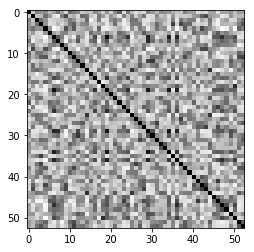

In [20]:
plt.imshow(venue_corr,cmap='Greys',interpolation='nearest')

In [22]:
scores=list()

# set number of clusters
#kclusters = 2

for kclusters in range(1,venue_corr.shape[0]):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_corr)

    # check cluster labelcs generated for each row in the dataframe
    #kmeans.labels_[0:10] 
    scores.append(kmeans.score(venue_corr))

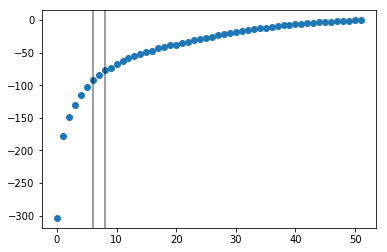

In [23]:
plt.axvline(6, color='k', alpha=0.5)
plt.axvline(8, color='k', alpha=0.5)
plt.scatter(np.linspace(0,len(scores)-1,len(scores)), scores)

,new label,corr_strength,cluster_size
0,1,0.395636,16
2,2,0.360580,7
1,3,0.247698,14
3,4,0.199617,16



 Cluster 1: ['French Restaurant', 'Farmers Market', 'Beer Bar', 'Plaza', 'American Restaurant', 'Theater', 'Concert Hall', 'Thai Restaurant', 'Steakhouse', 'Japanese Restaurant', 'Hotel', 'Seafood Restaurant', 'Art Gallery', 'Mediterranean Restaurant', 'Comic Shop', 'Museum']

 Cluster 2: ['Vegetarian / Vegan Restaurant', 'Arts & Crafts Store', 'Gym', 'Dessert Shop', 'Sporting Goods Shop', 'Bookstore', 'Movie Theater']

 Cluster 3: ['Breakfast Spot', 'Pub', 'BBQ Joint', 'Liquor Store', 'Grocery Store', 'Spa', 'Coffee Shop', 'Gastropub', 'Park', 'Indian Restaurant', 'Diner', 'Middle Eastern Restaurant', 'Italian Restaurant', 'Ice Cream Shop']

 Cluster 4: ['Café', 'Bakery', 'Pizza Place', 'Restaurant', 'Bar', 'Cocktail Bar', 'Yoga Studio', 'Sandwich Place', 'Vietnamese Restaurant', 'Sushi Restaurant', 'Tea Room', 'Brewery', 'Burger Joint', 'Mexican Restaurant', 'Asian Restaurant', 'Trail']


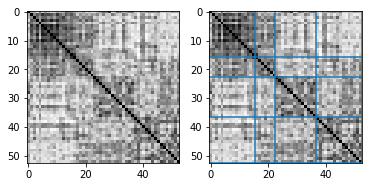

,new label,corr_strength,cluster_size
4,1,0.496188,14
2,2,0.383650,9
0,3,0.335018,7
3,4,0.330021,14
1,5,0.199648,9



 Cluster 1: ['Thai Restaurant', 'Concert Hall', 'Theater', 'Steakhouse', 'Seafood Restaurant', 'Farmers Market', 'Plaza', 'Art Gallery', 'Hotel', 'Mediterranean Restaurant', 'Comic Shop', 'Museum', 'Japanese Restaurant', 'Beer Bar']

 Cluster 2: ['Restaurant', 'Bar', 'Pizza Place', 'Cocktail Bar', 'Asian Restaurant', 'Sandwich Place', 'Brewery', 'Vietnamese Restaurant', 'Café']

 Cluster 3: ['Coffee Shop', 'Middle Eastern Restaurant', 'Liquor Store', 'Breakfast Spot', 'Gastropub', 'Diner', 'Pub']

 Cluster 4: ['Tea Room', 'Spa', 'BBQ Joint', 'Grocery Store', 'Trail', 'Ice Cream Shop', 'Yoga Studio', 'Burger Joint', 'Indian Restaurant', 'Park', 'Italian Restaurant', 'Bakery', 'Mexican Restaurant', 'Sushi Restaurant']

 Cluster 5: ['Movie Theater', 'Sporting Goods Shop', 'Dessert Shop', 'Bookstore', 'Arts & Crafts Store', 'Vegetarian / Vegan Restaurant', 'American Restaurant', 'Gym', 'French Restaurant']


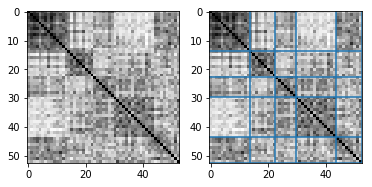

,new label,corr_strength,cluster_size
5,1,0.500112,7
1,2,0.496188,14
0,3,0.449038,8
4,4,0.383650,9
3,5,0.335018,7
2,6,0.269819,8



 Cluster 1: ['Trail', 'Burger Joint', 'Yoga Studio', 'Bakery', 'Mexican Restaurant', 'Tea Room', 'Sushi Restaurant']

 Cluster 2: ['Theater', 'Steakhouse', 'Thai Restaurant', 'Plaza', 'Concert Hall', 'Farmers Market', 'Seafood Restaurant', 'Japanese Restaurant', 'Hotel', 'Art Gallery', 'Mediterranean Restaurant', 'Comic Shop', 'Museum', 'Beer Bar']

 Cluster 3: ['BBQ Joint', 'Grocery Store', 'Indian Restaurant', 'Spa', 'French Restaurant', 'Park', 'Italian Restaurant', 'Ice Cream Shop']

 Cluster 4: ['Café', 'Sandwich Place', 'Brewery', 'Pizza Place', 'Restaurant', 'Bar', 'Cocktail Bar', 'Asian Restaurant', 'Vietnamese Restaurant']

 Cluster 5: ['Middle Eastern Restaurant', 'Liquor Store', 'Gastropub', 'Pub', 'Breakfast Spot', 'Diner', 'Coffee Shop']

 Cluster 6: ['Arts & Crafts Store', 'Gym', 'Dessert Shop', 'Bookstore', 'Sporting Goods Shop', 'Vegetarian / Vegan Restaurant', 'Movie Theater', 'American Restaurant']


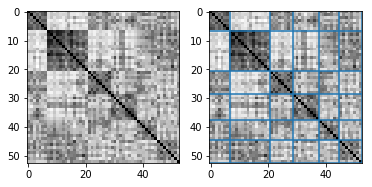

,new label,corr_strength,cluster_size
3,1,0.546972,3
5,2,0.501672,6
0,3,0.500112,7
2,4,0.496188,14
6,5,0.449038,8
4,6,0.360580,7
1,7,0.243764,8



 Cluster 1: ['Sandwich Place', 'Pizza Place', 'Restaurant']

 Cluster 2: ['Bar', 'Brewery', 'Cocktail Bar', 'Asian Restaurant', 'Vietnamese Restaurant', 'Café']

 Cluster 3: ['Yoga Studio', 'Bakery', 'Sushi Restaurant', 'Tea Room', 'Mexican Restaurant', 'Burger Joint', 'Trail']

 Cluster 4: ['Concert Hall', 'Farmers Market', 'Beer Bar', 'Steakhouse', 'Thai Restaurant', 'Seafood Restaurant', 'Art Gallery', 'Mediterranean Restaurant', 'Japanese Restaurant', 'Hotel', 'Comic Shop', 'Museum', 'Theater', 'Plaza']

 Cluster 5: ['BBQ Joint', 'Spa', 'Grocery Store', 'French Restaurant', 'Indian Restaurant', 'Park', 'Italian Restaurant', 'Ice Cream Shop']

 Cluster 6: ['Bookstore', 'Sporting Goods Shop', 'Movie Theater', 'Arts & Crafts Store', 'Vegetarian / Vegan Restaurant', 'Gym', 'Dessert Shop']

 Cluster 7: ['Gastropub', 'Breakfast Spot', 'American Restaurant', 'Liquor Store', 'Middle Eastern Restaurant', 'Diner', 'Pub', 'Coffee Shop']


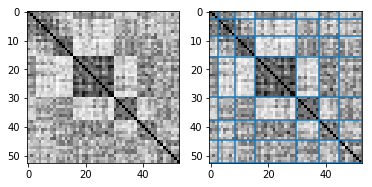

,new label,corr_strength,cluster_size
6,1,0.658671,3
0,2,0.590460,11
7,3,0.546972,3
2,4,0.501672,6
5,5,0.500112,7
1,6,0.449038,8
4,7,0.360580,7
3,8,0.243764,8



 Cluster 1: ['Beer Bar', 'Seafood Restaurant', 'Art Gallery']

 Cluster 2: ['Thai Restaurant', 'Steakhouse', 'Concert Hall', 'Farmers Market', 'Theater', 'Mediterranean Restaurant', 'Plaza', 'Japanese Restaurant', 'Hotel', 'Museum', 'Comic Shop']

 Cluster 3: ['Restaurant', 'Sandwich Place', 'Pizza Place']

 Cluster 4: ['Café', 'Cocktail Bar', 'Brewery', 'Asian Restaurant', 'Vietnamese Restaurant', 'Bar']

 Cluster 5: ['Yoga Studio', 'Burger Joint', 'Tea Room', 'Mexican Restaurant', 'Sushi Restaurant', 'Bakery', 'Trail']

 Cluster 6: ['Spa', 'BBQ Joint', 'Grocery Store', 'French Restaurant', 'Indian Restaurant', 'Park', 'Italian Restaurant', 'Ice Cream Shop']

 Cluster 7: ['Bookstore', 'Sporting Goods Shop', 'Movie Theater', 'Arts & Crafts Store', 'Vegetarian / Vegan Restaurant', 'Gym', 'Dessert Shop']

 Cluster 8: ['Gastropub', 'Breakfast Spot', 'American Restaurant', 'Liquor Store', 'Middle Eastern Restaurant', 'Diner', 'Pub', 'Coffee Shop']


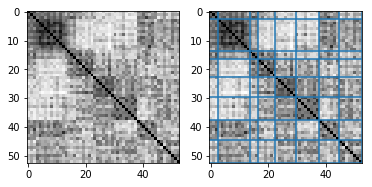

In [28]:
for i in range(4,9):
    clusterCorrelations(venue_corr, i, True)

In [837]:
restaurant_corr.columns

Index(['American Restaurant', 'French Restaurant', 'Seafood Restaurant',
       'Middle Eastern Restaurant', 'Mediterranean Restaurant',
       'Vegetarian / Vegan Restaurant', 'Restaurant', 'Thai Restaurant',
       'Vietnamese Restaurant', 'Indian Restaurant', 'Asian Restaurant',
       'Italian Restaurant', 'Japanese Restaurant', 'Sushi Restaurant',
       'Mexican Restaurant', 'cluster_labels'],
      dtype='object')

In [838]:
restaurants_1=restaurant_corr[restaurant_corr['cluster_labels']==1].index.values.tolist()
restaurants_2=restaurant_corr[restaurant_corr['cluster_labels']==2].index.values.tolist()

In [839]:
restaurant_corr.loc[restaurants_1, restaurants_1]

,Middle Eastern Restaurant,Indian Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant
Middle Eastern Restaurant,1.000000,0.376242,0.361741,0.045866,0.181094
Indian Restaurant,0.376242,1.000000,0.285230,0.225291,0.086724
Italian Restaurant,0.361741,0.285230,1.000000,0.477971,0.375210
Sushi Restaurant,0.045866,0.225291,0.477971,1.000000,0.327214
Mexican Restaurant,0.181094,0.086724,0.375210,0.327214,1.000000


In [840]:
toronto_onehot['restaurants_1']=toronto_onehot[restaurants_1].sum(axis=1)

In [841]:
toronto_onehot_restaurants_summed=toronto_onehot.drop(restaurants_1, axis=1)

In [842]:
venue_categories=pd.DataFrame({'venue_type':top_venue_types+['restaurants_1']})

In [843]:
venue_categories=venue_categories[~venue_categories.venue_type.isin(restaurants_1)].dropna()

In [844]:
top_venues=venue_categories.venue_type.tolist()

In [845]:
toronto_onehot=toronto_onehot_restaurants_summed[['Neighborhood']+top_venues]

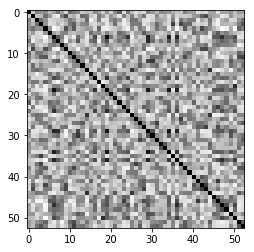

In [848]:
plt.imshow(venue_corr.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')
#plot_corr(restaurant_corr[restaurant_types])

In [849]:
scores=list()

# set number of clusters
#kclusters = 2

for kclusters in range(1,venue_corr.shape[0]):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_corr)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10] 
    scores.append(kmeans.score(venue_corr))

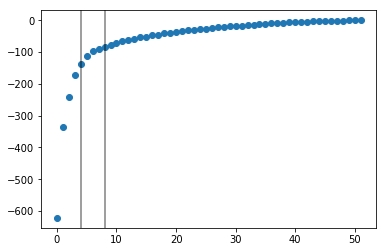

In [850]:
plt.axvline(4, color='k', alpha=0.5)
plt.axvline(8, color='k', alpha=0.5)
plt.scatter(np.linspace(0,len(scores)-1,len(scores)), scores)

,new label,corr_strength,cluster_size
1,1,0.590460,11
3,2,0.267046,13
0,3,0.231499,15
2,4,0.228912,14



 Cluster 1: ['Steakhouse', 'Museum', 'Comic Shop', 'Mediterranean Restaurant', 'Hotel', 'Japanese Restaurant', 'Farmers Market', 'Plaza', 'Concert Hall', 'Theater', 'Thai Restaurant']

 Cluster 2: ['Yoga Studio', 'Burger Joint', 'Brewery', 'Tea Room', 'Trail', 'Vietnamese Restaurant', 'Asian Restaurant', 'Sushi Restaurant', 'Cocktail Bar', 'Bar', 'Bakery', 'Café', 'Mexican Restaurant']

 Cluster 3: ['Spa', 'Grocery Store', 'Pub', 'BBQ Joint', 'Breakfast Spot', 'Liquor Store', 'Coffee Shop', 'French Restaurant', 'Indian Restaurant', 'Park', 'Diner', 'Middle Eastern Restaurant', 'Italian Restaurant', 'Ice Cream Shop', 'Gastropub']

 Cluster 4: ['Movie Theater', 'Pizza Place', 'Art Gallery', 'Seafood Restaurant', 'Restaurant', 'Sandwich Place', 'Sporting Goods Shop', 'Dessert Shop', 'Bookstore', 'Vegetarian / Vegan Restaurant', 'American Restaurant', 'Beer Bar', 'Gym', 'Arts & Crafts Store']


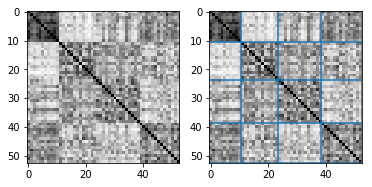

,new label,corr_strength,cluster_size
2,1,0.590460,11
0,2,0.441579,5
3,3,0.371863,9
1,4,0.323111,14
4,5,0.228912,14



 Cluster 1: ['Steakhouse', 'Museum', 'Comic Shop', 'Mediterranean Restaurant', 'Hotel', 'Japanese Restaurant', 'Farmers Market', 'Plaza', 'Concert Hall', 'Theater', 'Thai Restaurant']

 Cluster 2: ['Breakfast Spot', 'Pub', 'Diner', 'Coffee Shop', 'Gastropub']

 Cluster 3: ['Vietnamese Restaurant', 'Brewery', 'Asian Restaurant', 'Cocktail Bar', 'Bar', 'Bakery', 'Café', 'Yoga Studio', 'Mexican Restaurant']

 Cluster 4: ['Tea Room', 'Spa', 'Grocery Store', 'BBQ Joint', 'Liquor Store', 'French Restaurant', 'Trail', 'Burger Joint', 'Indian Restaurant', 'Park', 'Middle Eastern Restaurant', 'Italian Restaurant', 'Ice Cream Shop', 'Sushi Restaurant']

 Cluster 5: ['Movie Theater', 'Pizza Place', 'Art Gallery', 'Seafood Restaurant', 'Restaurant', 'Sandwich Place', 'Sporting Goods Shop', 'Dessert Shop', 'Bookstore', 'Vegetarian / Vegan Restaurant', 'American Restaurant', 'Beer Bar', 'Gym', 'Arts & Crafts Store']


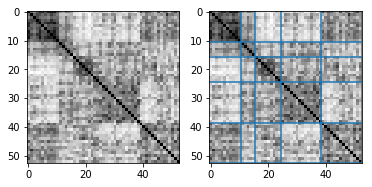

,new label,corr_strength,cluster_size
1,1,0.590460,11
0,2,0.526598,6
3,3,0.492884,7
4,4,0.441579,5
5,5,0.395824,10
2,6,0.228912,14



 Cluster 1: ['Museum', 'Comic Shop', 'Steakhouse', 'Mediterranean Restaurant', 'Hotel', 'Japanese Restaurant', 'Theater', 'Thai Restaurant', 'Plaza', 'Farmers Market', 'Concert Hall']

 Cluster 2: ['Trail', 'Yoga Studio', 'Mexican Restaurant', 'Burger Joint', 'Sushi Restaurant', 'Tea Room']

 Cluster 3: ['Asian Restaurant', 'Brewery', 'Bar', 'Cocktail Bar', 'Bakery', 'Café', 'Vietnamese Restaurant']

 Cluster 4: ['Pub', 'Breakfast Spot', 'Coffee Shop', 'Diner', 'Gastropub']

 Cluster 5: ['Liquor Store', 'Park', 'Italian Restaurant', 'BBQ Joint', 'Indian Restaurant', 'Spa', 'Ice Cream Shop', 'French Restaurant', 'Middle Eastern Restaurant', 'Grocery Store']

 Cluster 6: ['Bookstore', 'Dessert Shop', 'Vegetarian / Vegan Restaurant', 'Gym', 'Arts & Crafts Store', 'American Restaurant', 'Restaurant', 'Seafood Restaurant', 'Art Gallery', 'Pizza Place', 'Sporting Goods Shop', 'Movie Theater', 'Sandwich Place', 'Beer Bar']


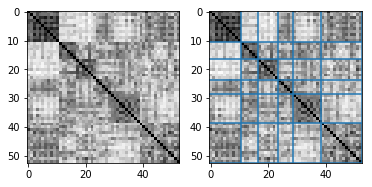

,new label,corr_strength,cluster_size
1,1,0.590460,11
6,2,0.526598,6
2,3,0.492884,7
3,4,0.441579,5
5,5,0.395824,10
0,6,0.371492,6
4,7,0.347721,8



 Cluster 1: ['Museum', 'Comic Shop', 'Steakhouse', 'Mediterranean Restaurant', 'Hotel', 'Japanese Restaurant', 'Theater', 'Thai Restaurant', 'Plaza', 'Farmers Market', 'Concert Hall']

 Cluster 2: ['Trail', 'Yoga Studio', 'Mexican Restaurant', 'Burger Joint', 'Sushi Restaurant', 'Tea Room']

 Cluster 3: ['Asian Restaurant', 'Brewery', 'Bar', 'Cocktail Bar', 'Bakery', 'Café', 'Vietnamese Restaurant']

 Cluster 4: ['Pub', 'Breakfast Spot', 'Coffee Shop', 'Diner', 'Gastropub']

 Cluster 5: ['Liquor Store', 'Park', 'Italian Restaurant', 'BBQ Joint', 'Indian Restaurant', 'Spa', 'Ice Cream Shop', 'French Restaurant', 'Middle Eastern Restaurant', 'Grocery Store']

 Cluster 6: ['Bookstore', 'Dessert Shop', 'Vegetarian / Vegan Restaurant', 'Gym', 'Sporting Goods Shop', 'Movie Theater']

 Cluster 7: ['Arts & Crafts Store', 'American Restaurant', 'Restaurant', 'Seafood Restaurant', 'Art Gallery', 'Pizza Place', 'Sandwich Place', 'Beer Bar']


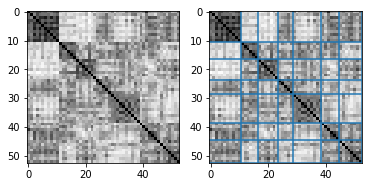

In [41]:
for i in range(4,8):
        clusterCorrelations(venue_corr, i, True)

We find a stable cluster of 11 venues wich are correlated the strongest amongst the set of top venues. 

In [42]:
top_cluster=['Museum', 'Comic Shop', 'Steakhouse', 'Mediterranean Restaurant', 'Hotel', 'Japanese Restaurant', 'Theater', 'Thai Restaurant', 'Plaza', 'Farmers Market', 'Concert Hall']

In [61]:
top_cluster_corr=venue_corr.loc[top_cluster, top_cluster]

We use the corelation amonst the cluster to make a prediction for the number of venues in each neighborhood bases on the other venues

In [62]:
toronto_top_cluster=toronto_onehot[['Neighborhood']+top_cluster].groupby('Neighborhood').sum()

In [63]:
top_cluster_predictions=toronto_top_cluster.copy()

In [104]:
for i in top_cluster:

    get_cluster=top_cluster.copy()
    get_cluster.remove(i)
    prediction=np.dot(np.array(toronto_top_cluster[get_cluster]),top_cluster_corr.loc[get_cluster, i].values.reshape((10,1)))/10

    top_cluster_predictions[[i]]=prediction

In [110]:
top_cluster_predictions[top_cluster]-toronto_top_cluster

,Museum,Comic Shop,Steakhouse,Mediterranean Restaurant,Hotel,Japanese Restaurant,Theater,Thai Restaurant,Plaza,Farmers Market,Concert Hall
Neighborhood,,,,,,,,,,,
"Adelaide, King, Richmond",0.079635,-0.212054,-0.493005,0.293252,-3.684512,-1.963568,-1.477969,-0.802465,-0.564122,-0.769006,-0.539085
Berczy Park,0.097341,0.817080,-0.447209,0.300616,-3.613924,-0.915721,-2.492217,-0.754044,-0.505572,-1.754506,-0.495998
"Brockton, Exhibition Place, Parkdale Village",0.322880,0.248881,0.514279,0.395630,-2.747488,-1.746051,-0.553575,-0.662312,0.491565,0.398039,0.462340
Business Reply Mail Processing Centre 969 Eastern,0.154018,-0.932691,0.150250,0.184440,-0.892671,0.112372,0.193772,0.158928,0.151017,-0.899869,0.176465
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0.522922,0.368440,-0.240899,-0.439422,-3.498917,-1.511528,-0.224064,0.601278,-1.354206,0.615035,0.767927
"Cabbagetown, St. James Town",0.838069,-1.403333,0.170087,-0.026364,-1.949334,-2.234081,-1.918816,-2.133683,0.113107,-0.033207,0.141383
Central Bay Street,-0.088037,-0.332225,-0.761059,0.083365,-1.817890,-2.145668,-1.805079,0.019003,0.239086,0.036273,-1.872094
"Chinatown, Grange Park, Kensington Market",0.332453,0.263725,-0.584272,-0.665362,-0.575590,-0.684459,-0.567301,-0.674189,0.471294,0.395422,-0.590724
Christie,-0.906916,0.104605,0.168263,0.156330,0.180249,-0.933951,0.169039,0.132982,0.139851,-0.918333,0.170504
